In [ ]:
import sys
import numpy as np
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist
from random import randint
import matplotlib.pyplot as plt

In [ ]:
class Discriminator(object):
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100):
        self.CAPACITY = width*height*channels
        self.SHAPE = (width, height, channels) # (28,28,1)을 기억하기 위함.
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)

        self.Discriminator = self.model()
        self.Discriminator.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER, metrics=['accuracy'] )
        self.summary()

    def model(self):
        model = Sequential()
        # 28,28,1 
        model.add(Flatten(input_shape=self.SHAPE))
        # 28*28*1 = (784,)
        model.add(Dense(self.CAPACITY, input_shape=self.SHAPE))
        # (28,28,1) -> (784)
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(int(self.CAPACITY/2)))
        # (784) -> (392)
        model.add(LeakyReLU(alpha=0.2))
        # (392) -> (1) : Sigmoid 0~1
        model.add(Dense(1, activation='sigmoid'))
        return model

    def summary(self):
        return self.Discriminator.summary()


In [ ]:
class Generator(object):
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100):
        self.W = width
        self.H = height
        self.C = channels
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)

        self.LATENT_SPACE_SIZE = latent_size
        self.latent_space = np.random.normal(0,1,(self.LATENT_SPACE_SIZE,))

        self.Generator = self.model()
        self.Generator.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)
        self.summary()

    def model(self, block_starting_size=128,num_blocks=4):
        model = Sequential()
        
        block_size = block_starting_size 
        model.add(Dense(block_size, input_shape=(self.LATENT_SPACE_SIZE,))) 
        # 가우시안 노이즈를 뿌려줘라!
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        for i in range(num_blocks-1):
            block_size = block_size * 2
            model.add(Dense(block_size))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.W * self.H * self.C, activation='tanh'))
        model.add(Reshape((self.W, self.H, self.C)))
        
        return model

    def summary(self):
        return self.Generator.summary()


In [ ]:
  class GAN(object):
    # Generator 를 학습 시키기 위한 부분
    def __init__(self,discriminator,generator):
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)
        self.Generator = generator
        self.Discriminator = discriminator
        self.Discriminator.trainable = False
        # 나중에 설명해줌.
        
        self.gan_model = self.model()
        self.gan_model.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)
        self.summary()

    def model(self):
        model = Sequential()
        model.add(self.Generator)
        model.add(self.Discriminator)
        return model

    def summary(self):
        return self.gan_model.summary()

In [ ]:
class Trainer:
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100, epochs =50000, batch=32, checkpoint=50,model_type=-1):
        self.W = width
        self.H = height
        self.C = channels
        self.EPOCHS = epochs
        self.BATCH = batch
        self.CHECKPOINT = checkpoint
        self.model_type=model_type
        # 왜 -1인지 나중 설명

        self.LATENT_SPACE_SIZE = latent_size

        self.generator = Generator(height=self.H, width=self.W, channels=self.C, latent_size=self.LATENT_SPACE_SIZE)
        self.discriminator = Discriminator(height=self.H, width=self.W, channels=self.C)
        self.gan = GAN(generator=self.generator.Generator, discriminator=self.discriminator.Discriminator)

        self.load_MNIST()

    def load_MNIST(self,model_type=7):
        allowed_types = [-1,0,1,2,3,4,5,6,7,8,9]
        if self.model_type not in allowed_types:
            print('ERROR: Only Integer Values from -1 to 9 are allowed')

        (self.X_train, self.Y_train), (_, _) = mnist.load_data()
        if self.model_type!=-1:
            self.X_train = self.X_train[np.where(self.Y_train==int(self.model_type))[0]]
            # 트레인 데이터의 해당 인덱스를 가져오기! where가 7의 데이터를 가진 인덱스를 반환

        
        # Rescale -1 to 1
        # Find Normalize Function from CV Class  
        # (0 ~ 255) -127.5 
        # (-127.5 ~ 127.5) / 127.5 
        # -1 ~ 1
        # 값을 알고있기에 127.5 쓰는거지 MinMaxNorm(0~1)*2 하고 -1 하면 정규화가 됨!!
        self.X_train = (np.float32(self.X_train) - 127.5) / 127.5
        self.X_train = np.expand_dims(self.X_train, axis=3)
        return

    def train(self):
        for e in range(self.EPOCHS):
            count_real_images = int(self.BATCH/2)
            starting_index = randint(0, (len(self.X_train)-count_real_images)) 
            # 60000에서 16 빼줘야 그 곳을 스타팅 포인트로 잡을수 있음
            # 16
            real_images_raw = self.X_train[ starting_index : (starting_index + count_real_images) ]
            x_real_images = real_images_raw.reshape( count_real_images, self.W, self.H, self.C )
            # (16,28,28,1) 16개 이미지
            y_real_labels = np.ones([count_real_images,1])
            # (16,1) 16개 이미지에 대한 정답. 다 진짜니까 1로 넣어줌.
            # (D(x_real_images), y_real_labels) 진짜를 진짜로 구분하지 못한 오차.
            # (D(x),1)

            # Grab Generated Images for this training batch
            latent_space_samples = self.sample_latent_space(count_real_images)
            x_generated_images = self.generator.Generator.predict(latent_space_samples)
            y_generated_labels = np.zeros([self.BATCH-count_real_images,1])

            # Combine to train on the discriminator
            x_batch = np.concatenate( [x_real_images, x_generated_images] )
            y_batch = np.concatenate( [y_real_labels, y_generated_labels] )

            # Now, train the discriminator with this batch
            discriminator_loss = self.discriminator.Discriminator.train_on_batch(x_batch,y_batch)[0]
        
            # Generate Noise
            if e % 5 == 0:
              x_latent_space_samples = self.sample_latent_space(self.BATCH)
              y_generated_labels = np.ones([self.BATCH,1])
              generator_loss = self.gan.gan_model.train_on_batch(x_latent_space_samples,y_generated_labels)
                
            if e % self.CHECKPOINT == 0 :
              print ('Epoch: '+str(int(e))+', [Discriminator :: Loss: '+str(discriminator_loss)+'], [ Generator :: Loss: '+str(generator_loss)+']')
              self.plot_checkpoint(e)
                        
        return

    def sample_latent_space(self, instances):
        return np.random.normal(0, 1, (instances, self.LATENT_SPACE_SIZE))

    def plot_checkpoint(self,e):
        noise = self.sample_latent_space(16)
        images = self.generator.Generator.predict(noise)
        
        plt.figure(figsize=(4,4))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = (image *127.5) + 127.5
            image = np.reshape(image*255.0, [self.H,self.W])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
#         plt.close('all')
        return

In [ ]:
# Command Line Argument Method
HEIGHT  = 28
WIDTH   = 28
CHANNEL = 1
LATENT_SPACE_SIZE = 100
EPOCHS = 5000
BATCH = 32
CHECKPOINT = 100
MODEL_TYPE = 5

In [ ]:
trainer = Trainer(height=HEIGHT,\
                 width=WIDTH,\
                 channels=CHANNEL,\
                 latent_size=LATENT_SPACE_SIZE,\
                 epochs =EPOCHS,\
                 batch=BATCH,\
                 checkpoint=CHECKPOINT,
                 model_type=MODEL_TYPE)



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1

In [ ]:
trainer.train()

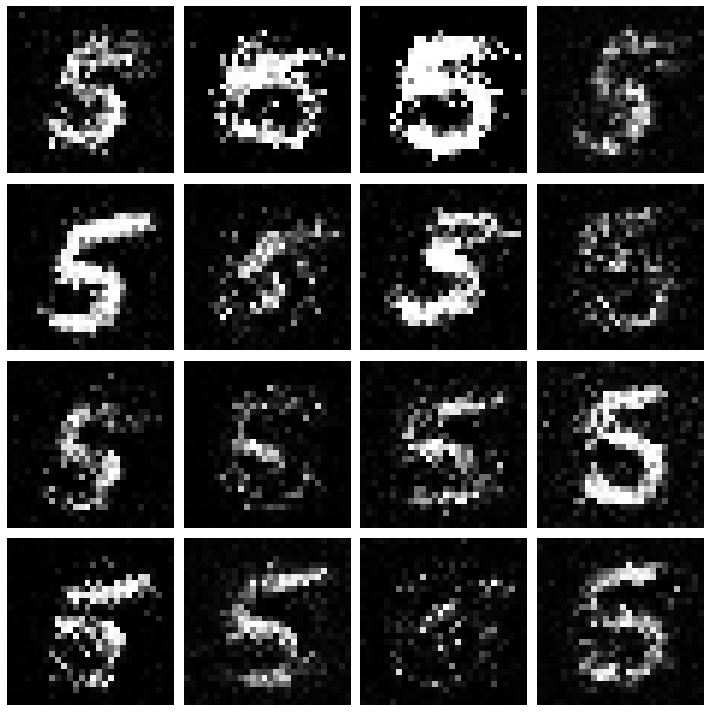

In [ ]:
noise = trainer.sample_latent_space(16)
images = trainer.generator.Generator.predict(noise)

plt.figure(figsize=(10,10))
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [28,28])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()